In [541]:
import pandas as pd
import json
from catboost import CatBoostRegressor
from ast import literal_eval

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

In [436]:
path_dataset = "../hfactory_magic_folders/hi__paris_hackaton/building_energy_efficiency/dataset/train"
path_x = "{}/train_features_sent.csv".format(path_dataset)
path_y = "{}/train_labels_sent.csv".format(path_dataset)

In [437]:
X = pd.read_csv(path_x)
Y = pd.read_csv(path_y)

/home/frank/anaconda3/envs/BCG/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [438]:
# X = X.iloc[:1000, :]
# Y = Y.iloc[:1000, :]

In [439]:
print(len(X))
print(len(Y))

1010684
1010684


In [440]:
df = pd.merge(X, Y, how="inner", on="level_0")

In [441]:
df_non_null_count = df.count()
col_valid = []
col_filtered = []
threshold = 0.21
total_rows = len(df)

print("Total number of columns: {}".format(total_rows))

for col, non_null in df_non_null_count.iteritems():
    if non_null > total_rows * threshold:
        col_valid.append(col)
    else:
        col_filtered.append(f"{col}, {non_null}")

df_filter1 = df[col_valid]

print(f"Filtered columns: {col_filtered}")
print(f"Number of filtered columns: {len(col_filtered)}")
print("Total number of validated columns: {}".format(len(col_valid)))

Total number of columns: 1010684
Filtered columns: ['additional_water_heaters, 209994', 'balcony_depth, 105791', 'nb_commercial_units, 116104', 'nb_gas_meters_commercial, 34476', 'nb_gas_meters_housing, 34476', 'nb_gas_meters_total, 34476', 'nb_housing_units, 116104', 'nb_parking_spaces, 116104', 'nb_power_meters_commercial, 95221', 'nb_power_meters_housing, 95221', 'nb_power_meters_total, 95221', 'nb_units_total, 116104', 'renewable_energy_sources, 9501']
Number of filtered columns: 13
Total number of validated columns: 59


In [442]:
df_filter1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010684 entries, 0 to 1010683
Data columns (total 59 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   level_0                           1010684 non-null  int64  
 1   additional_heat_generators        1010684 non-null  object 
 2   altitude                          992545 non-null   float64
 3   area_code                         1010684 non-null  int64  
 4   bearing_wall_material             956635 non-null   object 
 5   building_category                 1010684 non-null  object 
 6   building_class                    1010684 non-null  object 
 7   building_height_ft                994468 non-null   float64
 8   building_period                   1010684 non-null  object 
 9   building_total_area_sqft          949721 non-null   float64
 10  building_type                     1010684 non-null  object 
 11  building_use_type_code            101

# Information about categorical columns

In [336]:
cat_cols = df_filter1.select_dtypes(include="object").columns.to_list()
print("Category columns: ", cat_cols)
print("Number of category columns: ", len(cat_cols))

Category columns:  ['additional_heat_generators', 'bearing_wall_material', 'building_category', 'building_class', 'building_period', 'building_type', 'building_use_type_description', 'clay_risk_level', 'consumption_measurement_date', 'has_balcony', 'heat_generators', 'heating_energy_source', 'heating_type', 'is_crossing_building', 'lower_floor_adjacency_type', 'lower_floor_insulation_type', 'lower_floor_material', 'main_heat_generators', 'main_heating_type', 'main_water_heaters', 'main_water_heating_type', 'outer_wall_materials', 'outer_wall_thickness', 'radon_risk_level', 'roof_material', 'thermal_inertia', 'upper_floor_adjacency_type', 'upper_floor_insulation_type', 'upper_floor_material', 'ventilation_type', 'wall_insulation_type', 'water_heaters', 'water_heating_energy_source', 'water_heating_type', 'window_filling_type', 'window_frame_material', 'window_glazing_type', 'window_orientation']
Number of category columns:  38


In [254]:
df_cat = df_filter1[cat_cols]

In [262]:
df_cat_nunique = df_cat.nunique()

In [290]:
col_cat_valid = []
col_cat_filtered = []

threshold_categories = 30

for col, nunique in df_cat_nunique.iteritems():
    if nunique <= threshold_categories:
        col_cat_valid.append(col)
    else:
        col_cat_filtered.append(f"{col}, {nunique}")

print(col_cat_valid)
print(col_cat_filtered)

['additional_heat_generators', 'bearing_wall_material', 'building_period', 'building_type', 'building_use_type_description', 'clay_risk_level', 'has_balcony', 'heating_type', 'is_crossing_building', 'lower_floor_adjacency_type', 'lower_floor_insulation_type', 'lower_floor_material', 'main_heat_generators', 'main_water_heaters', 'outer_wall_materials', 'radon_risk_level', 'roof_material', 'thermal_inertia', 'upper_floor_adjacency_type', 'upper_floor_insulation_type', 'upper_floor_material', 'ventilation_type', 'wall_insulation_type', 'water_heating_energy_source', 'water_heating_type', 'window_filling_type', 'window_frame_material', 'window_glazing_type']
['building_category, 704', 'building_class, 1820', 'consumption_measurement_date, 2528', 'heat_generators, 1491', 'heating_energy_source, 60', 'main_heating_type, 33591', 'main_water_heating_type, 36346', 'outer_wall_thickness, 39', 'water_heaters, 174', 'window_orientation, 96']


In [508]:
print(len(df_cat_nunique))
print(len(col_cat_valid))
print(len(col_cat_filtered))

38
28
10


In [335]:
# TO MODIFY 
# building_category: explode + unique
# building_class: explode + unique
# consumption_measurement_date: convert to season
# heating_energy_source: split + n-hot
# main_heating_type: explode
# main_water_heating_type: explode + unique
# outer_wall_thickness: replace " et -" by "" and convert it to integer


# TO DELETE
# heat_generators: embedding 51 categories en un vector de 4
# water_heaters: embedding 36 categories en un vector de 3
# window_orientation: split " or " then encode vector de 4

In [368]:
df_cat['additional_heat_generators']

0          [wood stove or insert]
1                              []
2                              []
3                              []
4                              []
                    ...          
1010679                        []
1010680                        []
1010681     [standard gas boiler]
1010682                        []
1010683                        []
Name: additional_heat_generators, Length: 1010684, dtype: object

In [372]:
len(df_cat['additional_heat_generators'].values.reshape(1,-1))

1

In [348]:
col_cat = df_cat['additional_heat_generators'].dropna().unique()
col_cat

array(['[wood stove or insert]', '[]', '[low temperature oil boiler]',
       '[Joule effect generators]',
       '[lpg/butane/propane condensing boiler]', '[electric boiler]',
       '[standard oil boiler]', '[standard gas boiler]',
       '[low temperature gas boiler]',
       '[LPG/butane/propane standard boiler]', '[coal stove or insert]',
       '[gas condensing boiler]', '[LPG/butane/propane stove or insert]',
       '[geothermal heat pump]', '[indeterminate stove or insert]',
       '[standard coal-fired boiler]', '[air-to-air heat pump]',
       '[air-to-water heat pump]', '[water/water heat pump]',
       '[low temperature indeterminate energy boiler]', '[wood boiler]',
       '[indeterminate energy boiler indeterminate]',
       '[oil stove or insert]', '[oil condensing boiler]',
       '[heat network]', '[low temperature LPG/butane/propane boiler]',
       '[indeterminate wood heating]', '[radiateurs gaz]',
       '[chaudiere energie indetermine condensation]',
       '[pac 

In [339]:
newlist = []
size_list = []
for word in col_cat:
    word = word.replace('[', '')
    word = word.replace(']', '')
    word = word.split(" or ")
    size_list.append(len(word))
    newlist.extend(word)
# print(newlist)
print(len(set(newlist)))
print(set(newlist))
# print(max(size_list))

82
{'', 'west,north,sud', 'north,west,sud', 'est,west,sud', 'west,horizontal,north,west', 'west,horizontal,sud', 'est,horizontal,undetermined,west,sud', 'est,horizontal,north,west', 'horizontal,undetermined,north,west,sud', 'west,sud', 'est,horizontal', 'west,horizontal,undetermined,north,sud', 'est,sud', 'horizontal,north,west,sud', 'est,undetermined,north,west', 'undetermined,west,sud', 'west,horizontal,north,sud', 'est,north', 'est,north,sud', 'est,horizontal,north', 'horizontal,undetermined', 'undetermined,north,west,sud', 'est,horizontal,sud', 'est,undetermined,west', 'north,west', 'est,undetermined,north,sud', 'west,undetermined', 'west,horizontal,north', 'est,undetermined,north', 'horizontal,undetermined,sud', 'est,north,west', 'west,undetermined,north,west,sud', 'horizontal', 'est,undetermined,north,west,sud', 'est,west', 'est,horizontal,north,west,sud', 'west,north,west,sud', 'west,horizontal,west,sud', 'west,undetermined,west', 'west,north', 'est,horizontal,west,sud', 'undete

# Adapt categorical columns. Part 1

In [377]:
def get_encoder_mapping(dataframe, categorical_columns, verbose=False):
    encoder_mapping = {}
    
    for cat_col in categorical_columns:
        enc = OrdinalEncoder()
        temp_keys = dataframe[cat_col].values
        temp_values = enc.fit_transform(dataframe[cat_col].values.reshape(-1, 1)).tolist()
        encoder_mapping_col = dict(zip(temp_keys, temp_values))
        
        encoder_mapping[cat_col] = encoder_mapping_col
        if verbose:
            print(cat_col)
            print(encoder_mapping_col)
            print("\n")
    return encoder_mapping

In [381]:
encoding_map = get_encoder_mapping(df_filter1, col_cat_valid)
# print(encoding_map)
with open("encoding.json", "w") as outfile:
    json.dump(encoding_map, outfile)

In [392]:
cat_cols_valid = col_cat_valid
cat_cols_unvalid = col_cat_filtered
num_cols = list(set(df_filter1.columns).difference(set(cat_cols)))[1:]

In [394]:
cols_train = num_cols + cat_cols_valid
print(cols_train)

['altitude', 'solar_water_heating', 'post_code', 'building_year', 'upper_floor_thermal_conductivity', 'solar_heating', 'window_thermal_conductivity', 'area_code', 'energy_consumption_per_annum', 'lowe_floor_thermal_conductivity', 'window_heat_retention_factor', 'has_air_conditioning', 'nb_dwellings', 'building_height_ft', 'building_use_type_code', 'nb_meters', 'percentage_glazed_surfaced', 'living_area_sqft', 'outer_wall_thermal_conductivity', 'building_total_area_sqft', 'additional_heat_generators', 'bearing_wall_material', 'building_period', 'building_type', 'building_use_type_description', 'clay_risk_level', 'has_balcony', 'heating_type', 'is_crossing_building', 'lower_floor_adjacency_type', 'lower_floor_insulation_type', 'lower_floor_material', 'main_heat_generators', 'main_water_heaters', 'outer_wall_materials', 'radon_risk_level', 'roof_material', 'thermal_inertia', 'upper_floor_adjacency_type', 'upper_floor_insulation_type', 'upper_floor_material', 'ventilation_type', 'wall_insu

In [395]:
def encode(dataframe, encoding_map):
    for column, mapping in encoding_map.items():
        dataframe[column].replace(mapping, inplace=True)

In [397]:
df_cat1 = df_filter1.copy()
df_cat1 = df_cat1[cols_train]
encode(df_cat1, encoding_map)
df_cat1

,altitude,solar_water_heating,post_code,building_year,upper_floor_thermal_conductivity,solar_heating,window_thermal_conductivity,area_code,energy_consumption_per_annum,lowe_floor_thermal_conductivity,...,upper_floor_adjacency_type,upper_floor_insulation_type,upper_floor_material,ventilation_type,wall_insulation_type,water_heating_energy_source,water_heating_type,window_filling_type,window_frame_material,window_glazing_type
0,328.08400,False,45504141,1979.0,2.078260,False,15.347292,881,290.166345,2.844251,...,1.0,2.0,2.0,8.0,4.0,9.0,1.0,0.0,7.0,0.0
1,360.89240,False,40083759,NaN,2.078260,False,17.512631,260,169.818197,4.498072,...,1.0,0.0,9.0,12.0,4.0,4.0,1.0,0.0,8.0,0.0
2,324.80316,False,43247010,1810.0,1.790967,False,16.779108,573,144.499711,2.813221,...,3.0,2.0,13.0,10.0,4.0,4.0,1.0,1.0,7.0,0.0
3,288.71392,False,45471718,1972.0,1.811218,False,12.630033,204,158.742715,2.749757,...,1.0,2.0,5.0,3.0,4.0,3.0,1.0,NaN,2.0,4.0
4,849.73756,False,45783371,2012.0,1.770545,False,13.290529,374,82.223648,2.684326,...,1.0,2.0,3.0,4.0,4.0,12.0,1.0,1.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010679,1591.20740,True,66520288,1992.0,1.910007,False,14.649374,671,250.513236,2.844251,...,3.0,2.0,13.0,10.0,4.0,4.0,0.0,1.0,8.0,0.0
1010680,688.97640,False,60405560,2009.0,1.811218,False,11.348055,345,265.278733,2.582209,...,3.0,2.0,13.0,3.0,4.0,3.0,1.0,NaN,7.0,0.0
1010681,2805.11820,True,86018197,NaN,NaN,False,11.982461,205,311.681103,3.500730,...,NaN,2.0,9.0,12.0,4.0,17.0,1.0,0.0,7.0,0.0
1010682,708.66144,False,65083156,1970.0,2.235572,False,16.779108,451,340.538747,4.196129,...,3.0,2.0,5.0,12.0,7.0,9.0,1.0,0.0,7.0,0.0


# Adapt categorical columns. Part 2

In [407]:
cat_cols_unvalid

['building_category, 704',
 'building_class, 1820',
 'consumption_measurement_date, 2528',
 'heat_generators, 1491',
 'heating_energy_source, 60',
 'main_heating_type, 33591',
 'main_water_heating_type, 36346',
 'outer_wall_thickness, 39',
 'water_heaters, 174',
 'window_orientation, 96']

In [410]:
# TO MODIFY 
# building_category: explode + unique
# building_class: explode + unique
# consumption_measurement_date: convert to season
# heating_energy_source: split + n-hot
# main_heating_type: explode
# main_water_heating_type: explode + unique
# outer_wall_thickness: replace " et -" by "" and convert it to integer

In [427]:
df_col = df_cat[["building_category", "building_class"]]
len(df_col)

1010684

In [430]:
df_col.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010684 entries, 0 to 1010683
Data columns (total 2 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   building_category  1010684 non-null  object
 1   building_class     1010684 non-null  object
dtypes: object(2)
memory usage: 23.1+ MB


In [428]:
df_col = df_col.explode("building_category")

In [429]:
df_col

,building_category,building_class
0,[],[]
1,[condo],[2 to 11]
2,[],[]
3,[],[]
4,[individual house],[individual]
...,...,...
1010679,[individual house],[individual]
1010680,[],[]
1010681,[individual house],[individual]
1010682,[],[]


In [412]:
len(df_col)

1010684

In [446]:
df_col['building_category'].nunique()

704

In [533]:
df_col_sample = df_col[130:140]

In [534]:
df_col_sample

,building_category,building_class
130,,[]
131,individual house,[individual]
132,,[]
133,,[]
134,individual house,[individual]
135,"individual house,individual house","[individual,2 to 11]"
136,individual house,[individual]
137,"individual house,individual house,individual h...","[individual,individual,individual,individual,i..."
138,condo,[2 to 11]
139,individual house,[individual]


In [535]:
df_col_sample['building_category'] = df_col_sample['building_category'].str.replace(r"\[|\]",'')

/home/frank/anaconda3/envs/BCG/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/home/frank/anaconda3/envs/BCG/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [539]:
df_col_sample = df_col_sample.assign(building_category=df_col_sample['building_category'].str.split(",")).explode('building_category').drop_duplicates()

In [540]:
df_col_sample

,building_category,building_class
130,,[]
131,individual house,[individual]
135,individual house,"[individual,2 to 11]"
137,individual house,"[individual,individual,individual,individual,i..."
138,condo,[2 to 11]


In [503]:
df_col_sample['building_category'].str.split(',', expand=True)

,0,1,2,3,4,5,6,7,8,9
130,,None,None,None,None,None,None,None,None,None
131,individual house,None,None,None,None,None,None,None,None,None
132,,None,None,None,None,None,None,None,None,None
133,,None,None,None,None,None,None,None,None,None
134,individual house,None,None,None,None,None,None,None,None,None
135,individual house,individual house,None,None,None,None,None,None,None,None
136,individual house,None,None,None,None,None,None,None,None,None
137,individual house,individual house,individual house,individual house,individual house,individual house,individual house,individual house,individual house,individual house
138,condo,None,None,None,None,None,None,None,None,None
139,individual house,None,None,None,None,None,None,None,None,None


In [498]:
df_col_sample['building_category']

0                    
1               condo
2                    
3                    
4    individual house
5    individual house
6                    
7                    
8    individual house
9               condo
Name: building_category, dtype: object

In [518]:
df_col_sample.assign(building_category=df_col_sample.building_category.str.split(",")).explode('building_category')

,building_category,building_class
130,,[]
131,individual house,[individual]
132,,[]
133,,[]
134,individual house,[individual]
135,individual house,"[individual,2 to 11]"
135,individual house,"[individual,2 to 11]"
136,individual house,[individual]
137,individual house,"[individual,individual,individual,individual,i..."
137,individual house,"[individual,individual,individual,individual,i..."


In [ ]:
df_col_sample

In [497]:
# df_col['building_category'] = df_col.building_category.apply(lambda x: literal_eval(list(x)))

In [433]:
df_col = df_col.explode("building_category")

In [434]:
df_col

,building_category,building_class
0,[],[]
1,[condo],[2 to 11]
2,[],[]
3,[],[]
4,[individual house],[individual]
...,...,...
1010679,[individual house],[individual]
1010680,[],[]
1010681,[individual house],[individual]
1010682,[],[]


# Only with numeric columns

In [197]:
num_cols = list(set(df_filter1.columns).difference(set(cat_cols)))

In [198]:
num_cols = num_cols[1:]
num_cols

['altitude',
 'solar_water_heating',
 'post_code',
 'building_year',
 'upper_floor_thermal_conductivity',
 'solar_heating',
 'window_thermal_conductivity',
 'area_code',
 'energy_consumption_per_annum',
 'lowe_floor_thermal_conductivity',
 'window_heat_retention_factor',
 'has_air_conditioning',
 'nb_dwellings',
 'building_height_ft',
 'building_use_type_code',
 'nb_meters',
 'percentage_glazed_surfaced',
 'living_area_sqft',
 'outer_wall_thermal_conductivity',
 'building_total_area_sqft']

In [216]:
df_num = df_filter1[num_cols]

In [220]:
df_num.head()

,altitude,solar_water_heating,post_code,building_year,upper_floor_thermal_conductivity,solar_heating,window_thermal_conductivity,area_code,energy_consumption_per_annum,lowe_floor_thermal_conductivity,window_heat_retention_factor,has_air_conditioning,nb_dwellings,building_height_ft,building_use_type_code,nb_meters,percentage_glazed_surfaced,living_area_sqft,outer_wall_thermal_conductivity,building_total_area_sqft
0,328.08400,False,45504141,1979.0,2.078260,False,15.347292,881,290.166345,2.844251,1.116894,False,1,13.779528,1,NaN,0.847969,904.1676,4.364981,1291.6680
1,360.89240,False,40083759,NaN,2.078260,False,17.512631,260,169.818197,4.498072,1.133072,False,24,43.635172,2,5.0,0.750366,785.7647,3.364592,7136.4657
2,324.80316,False,43247010,1810.0,1.790967,False,16.779108,573,144.499711,2.813221,1.084204,False,2,19.685040,2,NaN,NaN,1162.5012,2.447516,4197.9210
3,288.71392,False,45471718,1972.0,1.811218,False,12.630033,204,158.742715,2.749757,0.983338,False,1,13.779528,1,NaN,0.748615,1937.5020,2.819698,1646.8767
4,849.73756,False,45783371,2012.0,1.770545,False,13.290529,374,82.223648,2.684326,1.084204,False,1,19.028872,1,1.0,0.662147,1087.1539,1.508377,1033.3344


# Filter NaN and split training and test

In [398]:
# replace by dataframe to be used
dataset = df_cat1

In [399]:
print(len(dataset))
dataset_non_na = dataset.dropna()
print(len(dataset_non_na))

1010684
222504


In [400]:
X_non_na = dataset_non_na.drop(["energy_consumption_per_annum"], axis=1)
Y_non_na = dataset_non_na["energy_consumption_per_annum"]

In [401]:
X_train, X_test, y_train, y_test = train_test_split(X_non_na, Y_non_na, test_size = 0.1, random_state = 0)

In [402]:
# cat_cols = X.select_dtypes(include="object").columns.to_list()
# print("Category columns: ", cat_cols)
# print("Number of Category columns: ", len(cat_cols))

In [403]:
print(len(X_train))
print(len(y_train))

200253
200253


# Training

In [404]:
# Initialize CatBoostRegressor
CBR = CatBoostRegressor(iterations=10,
                           learning_rate=1,
                           depth=2)
# for col in cat_cols:
#     X[col] = X[col].apply(str)

CBR.fit(X_train, y_train)
# model.fit(X_num_non_na, Y_num_non_na, cat_features=cat_cols)

y_pred = CBR.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print(f"The RMSE is :{rmse}")
evs = explained_variance_score(y_test, y_pred)
print(f"The explained variance score is :{evs}")
r2 = r2_score(y_test, y_pred)
print(f"{r2*100:.2f}% of the predictions are explained by our data.")

0:	learn: 89.6167390	total: 7.26ms	remaining: 65.3ms
1:	learn: 83.9410771	total: 13ms	remaining: 52.1ms
2:	learn: 81.0870385	total: 19.5ms	remaining: 45.4ms
3:	learn: 79.2715864	total: 25.9ms	remaining: 38.9ms
4:	learn: 77.5779503	total: 30.7ms	remaining: 30.7ms
5:	learn: 75.8054838	total: 37.3ms	remaining: 24.8ms
6:	learn: 74.5674104	total: 43.9ms	remaining: 18.8ms
7:	learn: 73.4355721	total: 49.3ms	remaining: 12.3ms
8:	learn: 72.6583559	total: 54.9ms	remaining: 6.1ms
9:	learn: 71.7853617	total: 60.9ms	remaining: 0us
The RMSE is :4729.536923952895
The explained variance score is :0.547623649495288
54.76% of the predictions are explained by our data.


In [405]:
RF = RandomForestRegressor(
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features = "auto",
    max_leaf_nodes = None,
    min_impurity_decrease = 0.0,
    bootstrap = True,
    oob_score = False,
    n_jobs = -1,
    warm_start = False,
    ccp_alpha = 0.0,
    max_samples = None,
    verbose=1
).fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   53.1s finished


In [406]:
y_pred = RF.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print(f"The RMSE is :{rmse}")
evs = explained_variance_score(y_test, y_pred)
print(f"The explained variance score is :{evs}")
r2 = r2_score(y_test, y_pred)
print(f"{r2*100:.2f}% of the predictions are explained by our data.")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


The RMSE is :2935.7467218732954
The explained variance score is :0.7192213315638107
71.92% of the predictions are explained by our data.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


# XGBRegressor

In [494]:
XGB = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
XGB.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

In [495]:
y_pred = XGB.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print(f"The RMSE is :{rmse}")
evs = explained_variance_score(y_test, y_pred)
print(f"The explained variance score is :{evs}")
r2 = r2_score(y_test, y_pred)
print(f"{r2*100:.2f}% of the predictions are explained by our data.")

The RMSE is :1910.7856967808925
The explained variance score is :0.8172297655254043
81.72% of the predictions are explained by our data.


<BarContainer object of 47 artists>

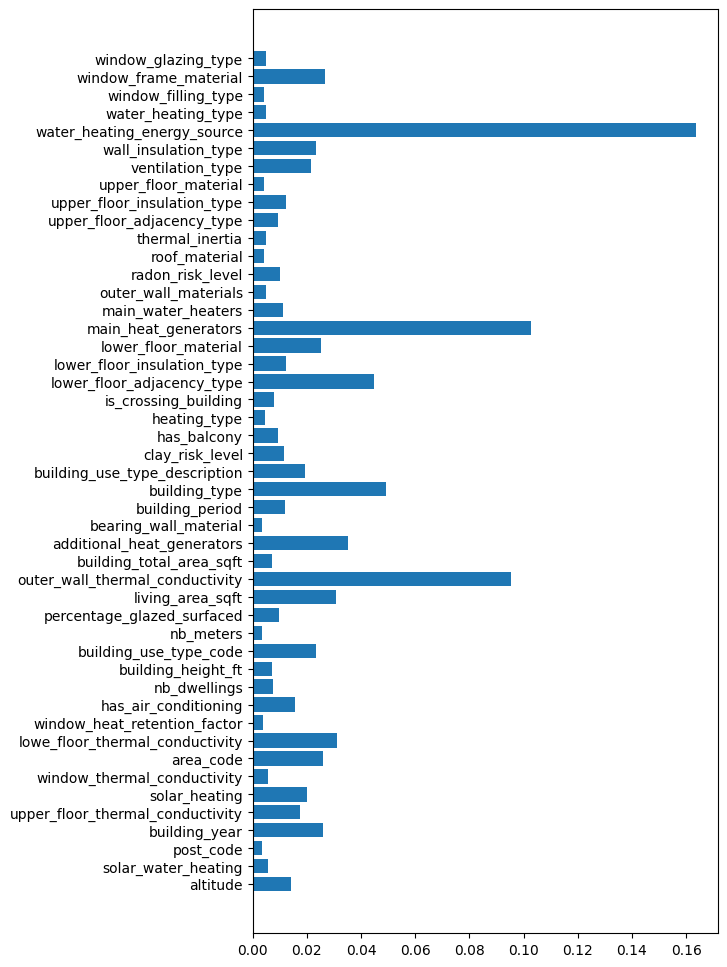

In [551]:
plt.figure(figsize=(6,12))
plt.barh(X_test.columns, XGB.feature_importances_)